<a href="https://www.kaggle.com/code/evelynartoria/fashionmnist-pytorch-tinyvgg?scriptVersionId=186893126" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


# Import needed libraries

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt

# Device agnostic code

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cpu


# Load csv files

In [5]:
train_csv = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
test_csv = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")
train_csv

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Build dataset

In [6]:
def make_dataset(csv):
    images = []
    labels = []
    for row in range(len(csv)):
        pixels = csv.iloc[row, 1:].values
        image = pixels.reshape(1, 28, 28)
        
        images.append(image)
        labels.append(csv.iloc[row, 0])
        
    images = torch.tensor(images, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    
    print(images.shape)
    print(labels.shape)
    
    dataset = TensorDataset(images, labels)
    
    return dataset

In [7]:
train_dataset = make_dataset(csv=train_csv)
test_dataset = make_dataset(csv=test_csv)

/opt/conda/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return func(*args, **kwargs)


torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


# Make the dataloader

In [8]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, generator=torch.Generator(device=device))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, generator=torch.Generator(device=device))

# Build the TinyVGG model

In [9]:
class TinyVGG(nn.Module):
    def __init__(self, n_inputs, hidden_units, n_classes):
        super().__init__()
        
        self.conv_kernel_size = 3
        
        self.conv2d_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_inputs, out_channels=hidden_units, kernel_size=self.conv_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=self.conv_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        self.conv2d_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=self.conv_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=self.conv_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=int(hidden_units*(28/(2*2))*(28/(2*2))), out_features=8*8*8),
            nn.ReLU(),
            nn.Linear(in_features=8*8*8, out_features=n_classes)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv2d_block_1(x)
        x = self.conv2d_block_2(x)
        x = self.classifier(x)
        return x

# Define model, optimizer and loss function

In [10]:
# model inputs must be batche (N x C x W x H)
tinyvgg = TinyVGG(n_inputs=1, hidden_units=3, n_classes=10)
optimizer = torch.optim.SGD(params=tinyvgg.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# Train loop

In [11]:
def train_model(model, train_dataloader, loss_fn, optimizer, epochs):
    for epoch in range(epochs):
        for batch, (images, labels) in enumerate(train_dataloader):
            logits = model(images)
            loss = loss_fn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch % 300 == 0:
                print(f"loss for batch {batch} --> {loss} at epoch {epoch}")
                
    print(f"loss for the very last batch --> {loss}")

In [12]:
train_model(model=tinyvgg, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, epochs=50)

loss for batch 0 --> 2.333885669708252 at epoch 0
loss for batch 300 --> 0.6197012662887573 at epoch 0
loss for batch 600 --> 0.5811905264854431 at epoch 0
loss for batch 900 --> 0.39863038063049316 at epoch 0
loss for batch 0 --> 0.5544638633728027 at epoch 1
loss for batch 300 --> 0.2968626618385315 at epoch 1
loss for batch 600 --> 0.5053044557571411 at epoch 1
loss for batch 900 --> 0.32785990834236145 at epoch 1
loss for batch 0 --> 0.43981748819351196 at epoch 2
loss for batch 300 --> 0.23313723504543304 at epoch 2
loss for batch 600 --> 0.5022278428077698 at epoch 2
loss for batch 900 --> 0.31441012024879456 at epoch 2
loss for batch 0 --> 0.4242556691169739 at epoch 3
loss for batch 300 --> 0.21338799595832825 at epoch 3
loss for batch 600 --> 0.49442440271377563 at epoch 3
loss for batch 900 --> 0.277040958404541 at epoch 3
loss for batch 0 --> 0.39478620886802673 at epoch 4
loss for batch 300 --> 0.21884100139141083 at epoch 4
loss for batch 600 --> 0.4877861440181732 at epoc

# Model inference

In [13]:
def show_image(tensor):
    plt.imshow(tensor.permute(1, 2, 0), cmap="gray")
    
def pred_random_image(model, dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    image = dataset[x][0]
    show_image(image.cpu())
    
    model.eval()
    with torch.inference_mode():
        logits = model(image.unsqueeze(dim=0)) # inputs must be batched
        pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        print(f"model predicted --> {pred.item()}")
        print(f"label is --> {dataset[x][1]}")
        

model predicted --> 8
label is --> 8


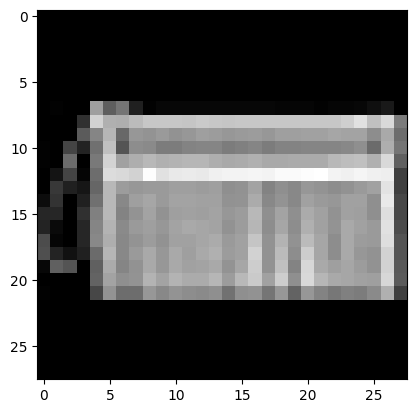

In [14]:
pred_random_image(model=tinyvgg, dataset=test_dataset)